In [ ]:
import sys
from simple_simulation_hardware import simple_processor
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
from qutip_qip.compiler import GateCompiler, Instruction
from qutip_qip.device import ModelProcessor
from qutip import (sigmax, sigmay, tensor)

import functools # for reduce
from qutip.qip.operations.gates import *
from qutip import basis
from qutip_qip.circuit import QubitCircuit
from qutip.metrics import fidelity
from qutip.qip.noise import RandomNoise

In [16]:
V = 1
omega = 10e6 # 10MHz

aNaught = 25 / 46

# Decoherence time
T1 = 8.66e-6
T1_err = 0.49
T2 = 9.08e-6
T2_err = 0.74e-6
T2_echo = 16.14e-6
T2_echo_err = 3.21e-6

In [83]:
pi_half_pulse_duration

1.8447474747474748

In [73]:
import numpy as np
from qutip_qip.operations import Gate
from qutip.qip.operations.gates import *
import itertools
from qutip import Qobj

__all__ = ['gate_set', 'matrix_list', 'add_inverse_gates']

def gates_set_generator(x):
    return [
    Gate("RX", 0, arg_value= x*np.pi), # X Pulse
    Gate("RY", 0, arg_value= x*np.pi), # Y Pulse
    Gate("RX", 0, arg_value= x*np.pi / 2), # X Half Pulse
    Gate("RY", 0, arg_value= x*np.pi / 2), # Y Half Pulse
    Gate("RX", 0, arg_value=- x*np.pi / 2), # X Minus Half Pulse
    Gate("RY", 0, arg_value=- x*np.pi / 2), # Y Minus Half Pulse
]

gates_set = gates_set_generator(pi_half_pulse_duration)

matrix_list = [
    rx(np.pi), # X
    ry(np.pi), # Y,
    rx(np.pi / 2), # X/2
    ry(np.pi / 2), # Y/2
    rx(-np.pi / 2), # -X/2
    ry(-np.pi / 2), # -Y/2
    rx(0)
]
        
def add_inverse_gates(clifford, init_state, matrix_list = matrix_list, gates_set = gates_set, circuit = None):
    """Add 0,1 or 2 gates that inverse the given gate(s)

        Args:
            clifford (qutip.Qobj): A qutip Qobj result from multiplying 
            the sequence of Clifford apply to the qubit.
            init_state (qutip.Qobj): The initial state.
            matrix_list (list of qutip.Qobj): A list of quantum gates in matrix form.
            gates_set (list of qutip_qip.circuit.Gate): A list of qutip Gate objects 
            that corresponds to the quantum gates given by matrix_list.
            circuit (qutip_qip.circuit.QubitCircuit): The circuit that the gates applied on.
        """
    def _inverse_search(state_before_inverse, init_state, matrix_list = matrix_list):
        """Find 2 gates from a list of gates that when apply to a given state give the initial state.

        Args:
            state_before_inverse (qutip.Qobj): The quantum state that need to be inversed.
            init_state (qutip.Qobj): The initial state.
            matrix_list (list of qutip.Qobj): A list of quantum gates in matrix form.

        Returns:
            index_list (tuple): The index (indicies) in the matrix list 
            of the two gates that inverse the state.
        """
        # Index of 2 gates that inverse the clifford sequence
        index_list = [i for i in itertools.product(range(len(matrix_list)), range(len(matrix_list)))]
        # Product of said 2 gates
        inverse_list = [i[0]*i[1] for i in itertools.product(matrix_list, matrix_list)]
        
        for i in range(len(inverse_list)):
            # Find final state after applying the 2 inverse gates and "normalize"
            final_state = inverse_list[i] * state_before_inverse
            if np.round(final_state[0][0][0],2) == 0:
                final_state = final_state/final_state[1][0][0]
            else:
                final_state = final_state/final_state[0][0][0]
            # Compare to ground state
            if np.allclose(final_state,init_state):
                return index_list[i]
    
    x = _inverse_search(clifford*init_state, init_state, matrix_list)
    if x == None:
        raise RuntimeError("Could not find an inverse Clifford")
    elif circuit == None:
        raise TypeError('NoneType object')
    elif not x[0] == 6 and not x[1] == 6:
        circuit.add_gate(gates_set[x[1]])
        circuit.add_gate(gates_set[x[0]])
    elif x[0] == 6 and not x[1] == 6:
        circuit.add_gate(gates_set[x[1]])
    elif x[1] == 6 and not x[0] == 6:
        circuit.add_gate(gates_set[x[0]])

In [74]:
class simple_compiler(GateCompiler):
    """
    Custom compiler for generating pulses from gates using
    the base class GateCompiler.

    Args:
        num_qubits (int): The number of qubits in the processor
        params (dict): A dictionary of parameters for gate pulses
                       such as the pulse amplitude.
    """

    def __init__(self, num_qubits, params):
        super().__init__(num_qubits, params=params)
        self.params = params
        self.gate_compiler = {
            "RX": self.pulse_discretization_compiler,
            "RY": self.pulse_discretization_compiler,
        }

    def generate_pulse(self, gate, tlist, coeff, phase=0.0):
        """Generates the pulses.

        Args:
            gate (qutip_qip.circuit.Gate): A qutip Gate object.
            tlist (array): A list of times for the evolution.
            coeff (array): An array of coefficients for the gate pulses
            phase (float): The value of the phase for the gate.

        Returns:
            Instruction (qutip_qip.compiler.instruction.Instruction):
            An instruction to implement a gate containing the control pulses.
        """
        pulse_info = [
            # (control label, coeff)
            ("sx" + str(gate.targets[0]), np.cos(phase) * coeff),
            ("sy" + str(gate.targets[0]), np.sin(phase) * coeff),
        ]
        return [Instruction(gate, tlist=tlist, pulse_info=pulse_info)]

    def pulse_discretization_compiler(self, gate, args):
        """Compiles single-qubit gates to pulses.

        Args:
            gate (qutip_qip.circuit.Gate): A qutip Gate object.

        Returns:
            Instruction (qutip_qip.compiler.instruction.Instruction):
            An instruction to implement a gate containing the control pulses.
        """
        # gate.arg_value is the rotation angle
        _step_list = np.linspace(0,1,11) # a time step list so that the noise work
        coupling_time_series = np.abs(gate.arg_value) / self.params["pulse_amplitude"] * _step_list
        s = aNaught - (1 - aNaught) * np.cos(2 * np.pi * _step_list[:-1])
        FPGA_voltage = self.params["pulse_amplitude"] * np.sign(gate.arg_value) * s
        if gate.name == "RX":
            return self.generate_pulse(gate, tlist = coupling_time_series, coeff = FPGA_voltage, phase=0.0)
        elif gate.name == "RY":
            return self.generate_pulse(gate, tlist = coupling_time_series, coeff = FPGA_voltage, phase=np.pi / 2)


In [75]:
def NTU_single_simple_simulation(num_gates, t1 = None, t2 = None, num_qubits = 1, 
                            add_FPGA_noise = False, FPGA_noise_strength = 0.3, 
                            pulse_amplitude = 1):
    """
    A single simulation, with num_gates representing the number of rotations.

    Args:
        num_gates (int): The number of random gates to add in the simulation.
        t1, t2 (float): Decoherence time of the qubits.
        add_FPGA_noise (bool): Whether to add in gaussian FPGA noise to the simulation.

    Returns:
        final_fidelity (float):
            Fidelity of the result state (obtained from 
            mesolve solver method) and the initial state.
    """
     
    myprocessor = simple_processor(num_qubits, t1 = t1, t2 = t2)
    myprocessor.native_gates = None  # Remove the native gates
    mycompiler = simple_compiler(num_qubits,{"pulse_amplitude": pulse_amplitude})

    # Ground state for n qubits
    init_state = functools.reduce(lambda a, b: tensor(a,b), [basis(2, 0)] * num_qubits)

    # Define a random circuit.
    circuit = QubitCircuit(num_qubits)
    clifford = rx(0)
    for ind in np.random.randint(0, 6, num_gates):
        circuit.add_gate(gates_set[ind])
        clifford = matrix_list[ind] * clifford

    # Finding inverse Clifford for the random sequence of gate
    add_inverse_gates(clifford, init_state, circuit = circuit)

    # Simulate the circuit.
    myprocessor.load_circuit(circuit, compiler=mycompiler)
    
    # FPGA gaussian noise
    if add_FPGA_noise == True:
        FPGA_noise = RandomNoise(dt=1e-9, rand_gen=np.random.normal, loc=0.00, scale = FPGA_noise_strength)
        myprocessor.add_noise(FPGA_noise)
    
    # Compute results of the run using a solver of choice
    result = myprocessor.run_state(init_state, solver="mesolve")
    # Measured fidelity at the end
    final_fidelity = fidelity(result.states[0],result.states[-1])
    return final_fidelity


In [90]:
def NTU_simulation_test_run(num_gates_list, num_sample, 
                        add_FPGA_noise = False, FPGA_noise_strength = 0.3, 
                        t1 = None, t2 = None,
                        pulse_amplitude = V*omega):
    fidelity_average = []
    fidelity_error = []
    for num_gates in num_gates_list:
        fidelity_list = [NTU_single_simple_simulation(
            num_gates, t1 = t1, t2 = t2, 
            add_FPGA_noise = add_FPGA_noise,
            FPGA_noise_strength = FPGA_noise_strength,
            pulse_amplitude = 20e6
            ) for i in range(num_sample)]
        fidelity_average.append(np.mean(fidelity_list))
        fidelity_error.append(np.std(fidelity_list) / np.sqrt(num_sample))
    
    return fidelity_average, fidelity_error

## Plot baseline vs with FPGA noise and decoherence

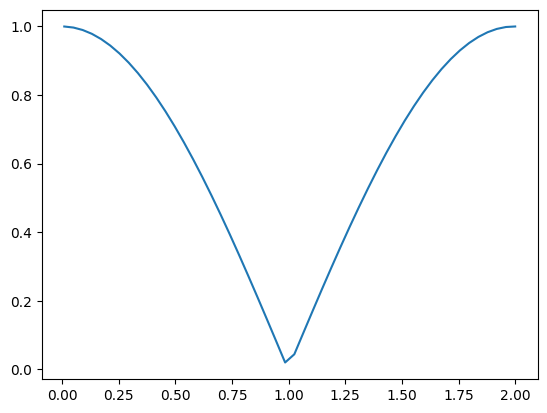

In [89]:
num_qubits =1
fidelity_list = []
index_list = []

for x in np.linspace(0.01,2,50):
    myprocessor = simple_processor(num_qubits)
    myprocessor.native_gates = None  # Remove the native gates
    mycompiler = simple_compiler(num_qubits,{"pulse_amplitude": 20e6})

    # Ground state for n qubits
    init_state = functools.reduce(lambda a, b: tensor(a,b), [basis(2, 0)] * num_qubits)

    # Define a random circuit.
    circuit = QubitCircuit(num_qubits)
    circuit.add_gate("RX", targets=0, arg_value=x*pi_half_pulse_duration*np.pi)

    # Simulate the circuit.
    myprocessor.load_circuit(circuit, compiler=mycompiler)
    
    # Compute results of the run using a solver of choice
    result = myprocessor.run_state(init_state, solver="mesolve")
    # Measured fidelity at the end
    final_fidelity = fidelity(result.states[0],result.states[-1])

    fidelity_list.append(final_fidelity)
    index_list.append(x)

plt.plot(index_list,fidelity_list)

In [79]:
from scipy.signal import argrelextrema

In [94]:
minimum_array = argrelextrema(np.asarray(fidelity_list), np.greater)
first_min = minimum_array[0][0]
pulse_coeff = index_list[first_min]/2
pulse_coeff

IndexError: index 0 is out of bounds for axis 0 with size 0

In [91]:
num_sample = 10
#num_gates_list = np.linspace(1,300,25,dtype=int)
num_gates_list = np.arange(5,105,20)

In [92]:
fidelity_baseline, error_baseline = NTU_simulation_test_run(
    num_gates_list, num_sample, 
    add_FPGA_noise = False, t1 = None, t2 = None)
fidelity_t1t2, error_t1t2 = NTU_simulation_test_run(
    num_gates_list, num_sample, 
    add_FPGA_noise = False, t1 = T1, t2 = T2)
fidelity_FPGA, error_FPGA = NTU_simulation_test_run(
    num_gates_list, num_sample, 
    add_FPGA_noise = True, t1 = None, t2 = None)
fidelity_FPGA_t1t2, error_FPGA_t1t2 = NTU_simulation_test_run(
    num_gates_list, num_sample, 
    add_FPGA_noise = True, t1 = T1, t2 = T2)

Text(0, 0.5, 'Ground State Fidelity')

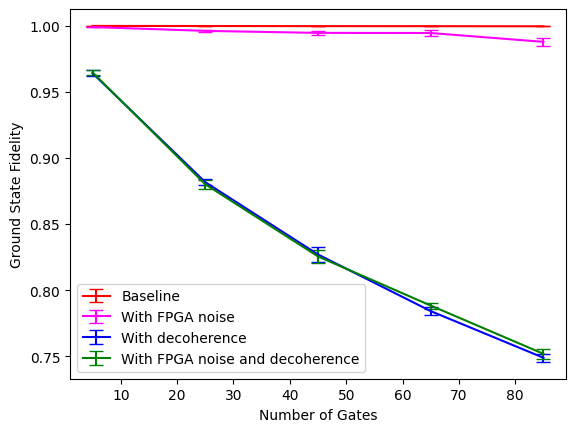

In [93]:
plt.autoscale(enable=True, axis="y", tight=False)
plt.errorbar(num_gates_list, fidelity_baseline, yerr=error_baseline, 
             color='red', capsize=5,label = 'Baseline')
plt.errorbar(num_gates_list, fidelity_FPGA, yerr=error_FPGA, 
             color='magenta', capsize=5, label = 'With FPGA noise')
plt.errorbar(num_gates_list, fidelity_t1t2, yerr=error_t1t2, 
             color='blue', capsize=5, label = 'With decoherence')
plt.errorbar(num_gates_list, fidelity_FPGA_t1t2, yerr=error_FPGA_t1t2, 
             color='green', capsize=5, label = 'With FPGA noise and decoherence')
plt.legend()
plt.xlabel("Number of Gates")
plt.ylabel("Ground State Fidelity")

Text(0, 0.5, 'Ground State Fidelity')

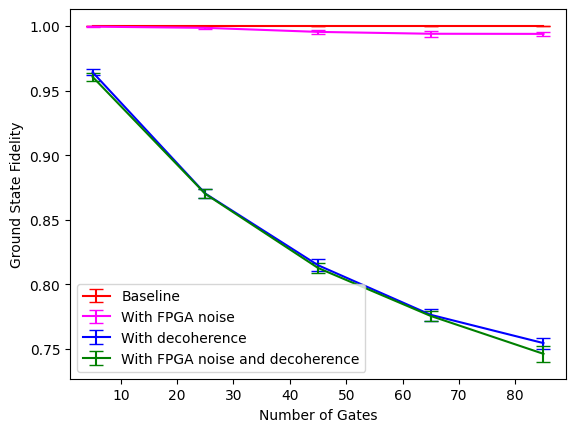

In [9]:
plt.autoscale(enable=True, axis="y", tight=False)
plt.errorbar(num_gates_list, fidelity_baseline, yerr=error_baseline, 
             color='red', capsize=5,label = 'Baseline')
plt.errorbar(num_gates_list, fidelity_FPGA, yerr=error_FPGA, 
             color='magenta', capsize=5, label = 'With FPGA noise')
plt.errorbar(num_gates_list, fidelity_t1t2, yerr=error_t1t2, 
             color='blue', capsize=5, label = 'With decoherence')
plt.errorbar(num_gates_list, fidelity_FPGA_t1t2, yerr=error_FPGA_t1t2, 
             color='green', capsize=5, label = 'With FPGA noise and decoherence')
plt.legend()
plt.xlabel("Number of Gates")
plt.ylabel("Ground State Fidelity")

## Plot fidelity of different noise strength

In [10]:
my_dict = {}
dictionary_key = []
for noise_strength in np.linspace(1/8000,1,20):
    fidelity_FPGA_t1t2, error_FPGA_t1t2 = NTU_simulation_test_run(
    num_gates_list, num_sample, 
    add_FPGA_noise = True, FPGA_noise_strength = noise_strength,
    t1 = 8.66e-6, t2 = 9.08e-6)
    dictionary_key = f"FPGA noise strength = {int(noise_strength*8000)}"
    my_dict[dictionary_key] = [fidelity_FPGA_t1t2, error_FPGA_t1t2]

KeyboardInterrupt: 

In [ ]:
plt.autoscale(enable=True, axis="y", tight=False)
for key in my_dict:
    plt.errorbar(num_gates_list, my_dict[key][0], yerr=my_dict[key][1], 
                capsize=5,label = key)
plt.legend(fontsize="5")
plt.xlabel("Number of Gates")
plt.ylabel("Ground State Fidelity")

## Plot fidelity against FPGA noise for the same number of gates

In [ ]:
fidelity_list = []
noise_list = []
error_list = []
for noise_strength in np.linspace(1/8000,1,20):
    fidelity_FPGA_t1t2, error_FPGA_t1t2 = NTU_simulation_test_run(
    [30], 30, 
    add_FPGA_noise = True, FPGA_noise_strength = noise_strength,
    t1 = 8.66e-6, t2 = 9.08e-6)
    fidelity_list.append(fidelity_FPGA_t1t2)
    noise_list.append(noise_strength)
    error_list.append(error_FPGA_t1t2)

In [ ]:
plt.autoscale(enable=True, axis="y", tight=False)
plt.plot(noise_list,fidelity_list)

plt.legend()
plt.xlabel("FPGA Voltage")
plt.ylabel("Ground State Fidelity")